In [0]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor
import pandas as pd

In [0]:
fact_bike_pred = (spark.table("hive_metastore.tfm.fact_bike_ml"))

In [0]:
display(fact_bike_pred.limit(10))

date,total,avg_distancia,awnd_bin,prcp_bin,snow_bin,snwd_bin,tmax_bin,tmin_bin,trange_bin,is_holiday,is_pre_holiday,is_weekend,day_of_week,month
2024-05-29,611,2.901460557216589,cat3,cat0,cat0,cat0,cat4,cat3,cat5,0,0,0,4,5
2024-09-07,129173,2.400920106199063,cat0,cat2,cat0,cat0,cat0,cat0,cat2,0,0,1,7,9
2024-10-14,120368,2.4713517271086394,cat1,cat0,cat0,cat0,cat0,cat0,cat2,1,0,0,2,10
2024-12-16,4919,1.7996580877721484,cat4,cat1,cat0,cat0,cat2,cat1,cat3,0,0,0,2,12
2024-04-19,105049,2.23592020906279,cat1,cat0,cat0,cat0,cat0,cat0,cat1,0,0,0,6,4
2024-12-09,46,null,null,null,null,null,null,null,null,0,0,0,2,12
2024-10-26,29,2.5365776004583642,cat6,cat0,cat0,cat0,cat3,cat2,cat4,0,0,1,7,10
2024-12-19,30,null,null,null,null,null,null,null,null,0,0,0,5,12
2024-07-29,87,null,null,null,null,null,null,null,null,0,0,0,2,7
2021-10-04,3721,1.8355061697456985,cat4,cat0,cat0,cat0,cat4,cat3,cat2,0,0,0,2,10


In [0]:
fact_bike_pred.count()

6840

VARIABLES TARGET: total y avg_distancia

# 1. TRATAMIENTO DE VALORES NULOS

In [0]:
null_counts = fact_bike_pred.select([
    F.count(F.when(F.col(c).isNull(), 1)).alias(c)
    for c in fact_bike_pred.columns
])

null_counts.show()

+----+-----+-------------+--------+--------+--------+--------+--------+--------+----------+----------+--------------+----------+-----------+-----+
|date|total|avg_distancia|awnd_bin|prcp_bin|snow_bin|snwd_bin|tmax_bin|tmin_bin|trange_bin|is_holiday|is_pre_holiday|is_weekend|day_of_week|month|
+----+-----+-------------+--------+--------+--------+--------+--------+--------+----------+----------+--------------+----------+-----------+-----+
|   0|    0|          711|     843|     843|     843|     843|     843|     843|       843|         0|             0|         0|          0|    0|
+----+-----+-------------+--------+--------+--------+--------+--------+--------+----------+----------+--------------+----------+-----------+-----+



Se eliminarán los 843 registros en los que las columnas categorizadas (bins) presentan valores nulos. Estos casos corresponden a viajes en los que no se dispone de información sobre la estación de origen en la tabla de bicicletas, lo que impide realizar correctamente el join con la estación meteorológica más cercana. En consecuencia, al no conocerse el punto de inicio del trayecto, no es posible asociar de forma fiable las condiciones climáticas correspondientes, por lo que dichos registros se excluyen del análisis.

In [0]:
fact_bike_pred = (
    fact_bike_pred
    .where(F.col('awnd_bin').isNotNull())
)

In [0]:
display(fact_bike_pred.limit(10))

date,total,avg_distancia,awnd_bin,prcp_bin,snow_bin,snwd_bin,tmax_bin,tmin_bin,trange_bin,is_holiday,is_pre_holiday,is_weekend,day_of_week,month
2024-06-16,651,2.578165933941116,cat4,cat0,cat0,cat0,cat4,cat3,cat4,0,0,1,1,6
2024-08-14,15122,2.3078782758336813,cat3,cat0,cat0,cat0,cat5,cat4,cat4,0,0,0,4,8
2024-08-16,15771,2.986988974321839,cat3,cat0,cat0,cat0,cat5,cat4,cat3,0,0,0,6,8
2024-10-28,133403,2.401593656659409,cat0,cat0,cat0,cat0,cat0,cat0,cat1,0,0,0,2,10
2024-10-17,30,3.6202540750664727,cat5,cat0,cat0,cat0,cat3,cat1,cat5,0,0,0,5,10
2024-12-01,52020,2.108833743915437,cat1,cat0,cat0,cat0,cat0,cat0,cat0,0,0,1,1,12
2024-02-19,52979,1.9913719116901019,cat1,cat0,cat0,cat0,cat0,cat0,cat0,1,0,0,2,2
2024-02-22,5408,1.9907685416563605,cat4,cat0,cat0,cat0,cat1,cat0,cat1,0,0,0,5,2
2024-03-16,101587,2.3953049979127528,cat0,cat0,cat0,cat0,cat0,cat0,cat1,0,0,1,7,3
2024-03-14,24,2.4532704660387776,cat2,cat0,cat0,cat0,cat3,cat1,cat6,0,0,0,5,3


In [0]:
null_counts = fact_bike_pred.select([
    F.count(F.when(F.col(c).isNull(), 1)).alias(c)
    for c in fact_bike_pred.columns
])

null_counts.show()

+----+-----+-------------+--------+--------+--------+--------+--------+--------+----------+----------+--------------+----------+-----------+-----+
|date|total|avg_distancia|awnd_bin|prcp_bin|snow_bin|snwd_bin|tmax_bin|tmin_bin|trange_bin|is_holiday|is_pre_holiday|is_weekend|day_of_week|month|
+----+-----+-------------+--------+--------+--------+--------+--------+--------+----------+----------+--------------+----------+-----------+-----+
|   0|    0|            0|       0|       0|       0|       0|       0|       0|         0|         0|             0|         0|          0|    0|
+----+-----+-------------+--------+--------+--------+--------+--------+--------+----------+----------+--------------+----------+-----------+-----+



In [0]:
fact_bike_pred.count()

5997

# 2. TRATAMIENTO DE OUTLIERS

## 2.1 Columna TOTAL

In [0]:
#Calculo de limites IQR
q1_total, q3_total = fact_bike_pred.approxQuantile('total', [0.25, 0.75], 0.01)
iqr_total = q3_total - q1_total

lower_total = q1_total - (1.5 * iqr_total)
upper_total = q3_total + (1.5 * iqr_total)

In [0]:
#Mostreo de datos para visualización
sample_pd_total = (
    fact_bike_pred
    .select('total')
    .sample(fraction=0.05, seed=42)
    .toPandas()
)

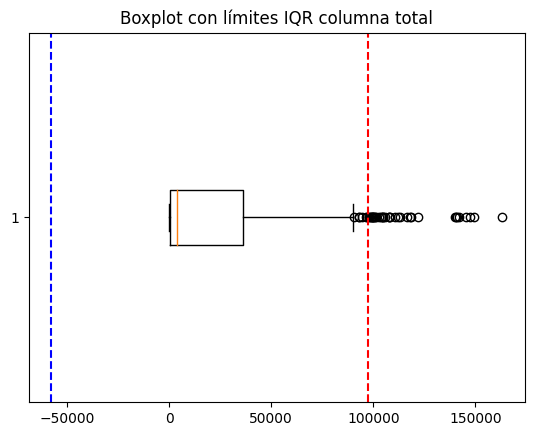

In [0]:
#Boxplot
plt.boxplot(sample_pd_total['total'], vert=False)
plt.axvline(lower_total, color='blue', linestyle='--')
plt.axvline(upper_total, color='red', linestyle='--')
plt.title('Boxplot con límites IQR columna total')
plt.show()

Diante del analisis boxplot se evidencia un número elevado de valores atípicos. Estos valores representan situaciones reales de alta demanda, por lo tanto optaré por una transformación logarítmica para reducir la asimetria.

In [0]:
fact_bike_pred = (
    fact_bike_pred
        .withColumn(
        'total_log',
        F.log1p(F.col('total'))
    )
)

Recalculando datos utilizando la nueva columna total_log

In [0]:
#Calculo de limites IQR
q1_totallog, q3_totallog = fact_bike_pred.approxQuantile('total_log', [0.25, 0.75], 0.01)
iqr_totallog = q3_totallog - q1_totallog

lower_totallog = q1_totallog - (1.5 * iqr_totallog)
upper_totallog = q3_totallog + (1.5 * iqr_totallog)

In [0]:
#Mostreo de datos para visualización
sample_pd_totallog = (
    fact_bike_pred
    .select('total_log')
    .sample(fraction=0.05, seed=42)
    .toPandas()
)

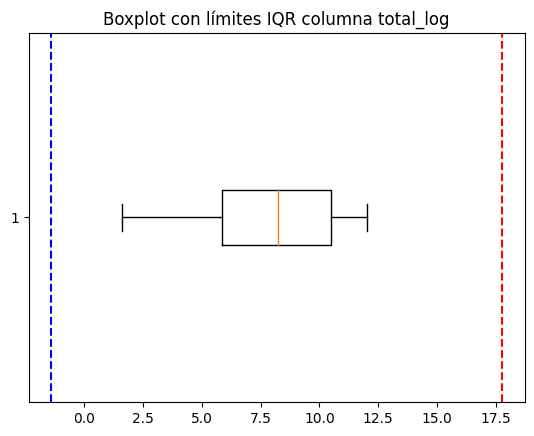

In [0]:
plt.boxplot(sample_pd_totallog['total_log'], vert=False)
plt.axvline(lower_totallog, color='blue', linestyle='--')
plt.axvline(upper_totallog, color='red', linestyle='--')
plt.title('Boxplot con límites IQR columna total_log')
plt.show()

## 2.2 COLUMNA AVG_DISTANCIA

In [0]:
#Calculo de limites IQR
q1_dist, q3_dist = fact_bike_pred.approxQuantile('avg_distancia', [0.25, 0.75], 0.01)
iqr_dist = q3_dist - q1_dist

lower_dist = q1_dist - (1.5 * iqr_dist)
upper_dist = q3_dist + (1.5 * iqr_dist)

In [0]:
#Mostreo de datos para visualización
sample_pd_dist = (
    fact_bike_pred
    .select('avg_distancia')
    .sample(fraction=0.05, seed=42)
    .toPandas()
)

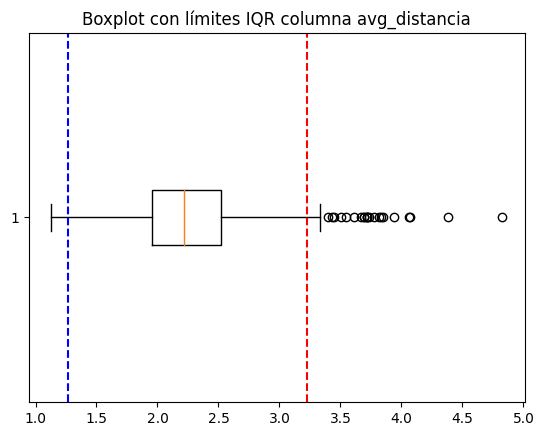

In [0]:
#Boxplot
plt.boxplot(sample_pd_dist['avg_distancia'], vert=False)
plt.axvline(lower_dist, color='blue', linestyle='--')
plt.axvline(upper_dist, color='red', linestyle='--')
plt.title('Boxplot con límites IQR columna avg_distancia')
plt.show()

Aunque la variable de distancia media presenta cierta asimetría, esta es menor en comparación a variable total
De momento, se mantendrá la columna avg_distancia en su escala original pero posteriormente el modelo será entrenado con avg_distancia original y en escala logaritimica para comparar resultados.

# 3. ENTRENAMIENTO DE MODELOS

In [0]:
#Crear columnas de target
fact_bike_pred = (
    fact_bike_pred
    .withColumn(
        'y1',
        F.col('total_log')
    )
    .withColumn(
        'y2',
        F.col('avg_distancia')
    )
)

## 3.1 Partición train/validation/test

Como se trata de una serie temporal con distintos años, para evitar la aleatoriedad completa del split, los datos serán separados previamente por año. Dentro de cada año se realizará la división de conjuntos y posteriormente se unirán los subconjuntos correspondientes

In [0]:
#2020
df20 = (
    fact_bike_pred
    .filter(F.year(F.col('date')) == 2020)
)

train_df20, val_df20, test_df20 = df20.randomSplit(
    [0.7, 0.15, 0.15],
    seed=42
)

#2021
df21 = (
    fact_bike_pred
    .filter(F.year(F.col('date')) == 2021)
)

train_df21, val_df21, test_df21 = df21.randomSplit(
    [0.7, 0.15, 0.15],
    seed=42
)

#2022
df22 = (
    fact_bike_pred
    .filter(F.year(F.col('date')) == 2022)
)

train_df22, val_df22, test_df22 = df22.randomSplit(
    [0.7, 0.15, 0.15],
    seed=42
)

#2023
df23 = (
    fact_bike_pred
    .filter(F.year(F.col('date')) == 2023)
)

train_df23, val_df23, test_df23 = df23.randomSplit(
    [0.7, 0.15, 0.15],
    seed=42
)

#2024
df24 = (
    fact_bike_pred
    .filter(F.year(F.col('date')) == 2024)
)

train_df24, val_df24, test_df24 = df24.randomSplit(
    [0.7, 0.15, 0.15],
    seed=42
)

In [0]:
train_df = (
    train_df20
    .union(train_df21)
    .union(train_df22)
    .union(train_df23)
    .union(train_df24)
)

val_df = (
    val_df20
    .union(val_df21)
    .union(val_df22)
    .union(val_df23)
    .union(val_df24)
)

test_df = (
    test_df20
    .union(test_df21)
    .union(test_df22)
    .union(test_df23)
    .union(test_df24)
)

In [0]:
train_df.cache()
val_df.cache()
test_df.cache()

train_df.count()
val_df.count()
test_df.count()

735

## 3.2 Entrenamiento del modelo

In [0]:
indexers = [
    StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="keep")
    for c in [
        'awnd_bin', 'prcp_bin', 'snow_bin', 'snwd_bin',
        'tmax_bin', 'tmin_bin', 'trange_bin'
    ]
]

In [0]:
feature_cols = [
    'awnd_bin_idx', 'prcp_bin_idx', 'snow_bin_idx', 'snwd_bin_idx',
    'tmax_bin_idx', 'tmin_bin_idx', 'trange_bin_idx',
    'is_holiday', 'is_pre_holiday', 'is_weekend',
    'day_of_week', 'month'
]

In [0]:
assembler = VectorAssembler(
    inputCols = feature_cols,
    outputCol = 'features',
    handleInvalid = 'keep'
)

***MODELO 1: REGRESIÓN LINEAR***

_(Variable target: total_log)_

In [0]:
#Modelo Regresión Linear
label_col = 'y1'

model1 = LinearRegression(
    featuresCol = 'features',
    labelCol = label_col
)

In [0]:
#Pipeline
pipeline1 = Pipeline(
    stages=indexers + [assembler, model1]
)

In [0]:
#Train
model_fitted1 = pipeline1.fit(train_df)

In [0]:
#Train + Val

pred_val1 = model_fitted1.transform(val_df)

rmse_eval1 = RegressionEvaluator(
    labelCol=label_col,
    predictionCol="prediction",
    metricName="rmse"
)

r2_eval1 = RegressionEvaluator(
    labelCol=label_col,
    predictionCol="prediction",
    metricName="r2"
)

rmse_val1 = rmse_eval1.evaluate(pred_val1)
r2_val1 = r2_eval1.evaluate(pred_val1)

rmse_val1, r2_val1

(2.8352200836173647, 0.03059676210688478)

***MODELO 1: REGRESIÓN LINEAR***

_(Variable target: avg_distancia)_

In [0]:
#Modelo Regresión Linear
label_col = 'y2'

model2 = LinearRegression(
    featuresCol = 'features',
    labelCol = label_col
)

In [0]:
#Pipeline
pipeline2 = Pipeline(
    stages=indexers + [assembler, model2]
)

In [0]:
#Train
model_fitted2 = pipeline2.fit(train_df)

In [0]:
#Train + Val

pred_val2 = model_fitted2.transform(val_df)

rmse_eval2 = RegressionEvaluator(
    labelCol=label_col,
    predictionCol="prediction",
    metricName="rmse"
)

r2_eval2 = RegressionEvaluator(
    labelCol=label_col,
    predictionCol="prediction",
    metricName="r2"
)

rmse_val2 = rmse_eval2.evaluate(pred_val2)
r2_val2 = r2_eval2.evaluate(pred_val2)

rmse_val2, r2_val2

(0.5101064400642917, 0.04977683208381434)

_**MODELO 2: RANDOM FOREST**_

_(Variable target: total_log)_

In [0]:
#Modelo RF
label_col = 'y1'

rf1 = RandomForestRegressor(
    labelCol=label_col,
    featuresCol="features",
    numTrees=100,
    maxDepth=8,
    seed=42
)

In [0]:
#Pipeline
pipeline_rf1 = Pipeline(
    stages=indexers + [assembler, rf1]
)

In [0]:
#Train + val
rf_model1 = pipeline_rf1.fit(train_df)

pred_val_rf1 = rf_model1.transform(val_df)

rmse_rf1 = rmse_eval1.evaluate(pred_val_rf1)
r2_rf1 = r2_eval1.evaluate(pred_val_rf1)

rmse_rf1, r2_rf1

(1.8255177805479, 0.5981138427113609)

_**MODELO 2: RANDOM FOREST**_

_(Variable target: avg_distancia)_

In [0]:
#Modelo RF
label_col = 'y2'

rf2 = RandomForestRegressor(
    labelCol=label_col,
    featuresCol="features",
    numTrees=100,
    maxDepth=8,
    seed=42
)

In [0]:
#Pipeline
pipeline_rf2 = Pipeline(
    stages=indexers + [assembler, rf2]
)

In [0]:
#Train + val
rf_model2 = pipeline_rf2.fit(train_df)

pred_val_rf2 = rf_model2.transform(val_df)

rmse_rf2 = rmse_eval2.evaluate(pred_val_rf2)
r2_rf2 = r2_eval2.evaluate(pred_val_rf2)

rmse_rf2, r2_rf2

(0.48714340938348266, 0.13340203555241903)

Modelo elegido: Random Forest, ya que es el modelo que mejor explica la variabilidad de la variable objetivo

## 3.3 Evaluación final en el conjunto de prueba

In [0]:
#Variable total_log

pred_test1 = rf_model1.transform(test_df)

rmse_test1 = rmse_eval1.evaluate(pred_test1)
r2_test1 = r2_eval1.evaluate(pred_test1)

rmse_test1, r2_test1

(1.6933550620771525, 0.6495069536065523)

In [0]:
#Variable avg_distancia

pred_test2 = rf_model2.transform(test_df)

rmse_test2 = rmse_eval2.evaluate(pred_test2)
r2_test2 = r2_eval2.evaluate(pred_test2)

rmse_test2, r2_test2

(0.4738911336452758, 0.14355233574354032)

#4. GUARDAR PREVISIONES

In [0]:
pred_to_save1 = (
    pred_test1
    .withColumn(
        'prediction_exp_total',
        F.exp(F.col('prediction'))
    )
    .select(
        'date',
        'prediction_exp_total'
    )
)

display(pred_to_save1.limit(10))

date,prediction_exp_total
2020-01-03,392.17984966552063
2020-01-03,37256.79766581139
2020-01-08,33489.73653776257
2020-01-12,38023.24376523886
2020-01-16,342.6248741020188
2020-01-16,40904.05049319419
2020-01-17,282.99967023290526
2020-01-18,244.16007129499826
2020-01-19,185.13538539506777
2020-01-21,26176.994803710306


In [0]:
pred_to_save1 = (
    pred_to_save1
    .groupBy('date')
    .agg(F.sum('prediction_exp_total').alias('prediction_total'))
)

In [0]:
display(pred_to_save1.limit(10))

date,prediction_total
2020-03-13,412.44150559818695
2020-01-25,255.6146134033531
2020-04-13,47463.245064746676
2020-06-28,757.423701127512
2020-07-28,1445.7609672101432
2020-04-24,1004.5791308152413
2020-07-16,77384.89126784749
2020-09-11,1348.6732650604297
2020-07-17,978.7656224155343
2020-05-05,602.405573665044


In [0]:
pred_to_save2 = (
    pred_test2
    .withColumn(
        'prediction_exp_avg_distancia',
        F.exp(F.col('prediction'))
    )
    .select(
        'date',
        'prediction_exp_avg_distancia'
    )
)

display(pred_to_save2.limit(10))

date,prediction_exp_avg_distancia
2020-01-03,8.13648437783448
2020-01-03,7.490322939332611
2020-01-08,7.531969334822808
2020-01-12,10.532028006466756
2020-01-16,8.236801712333488
2020-01-16,7.5394465347883495
2020-01-17,7.4545972153358555
2020-01-18,6.912747863860195
2020-01-19,9.48613100610417
2020-01-21,7.09892773266742


In [0]:
pred_to_save2 = (
    pred_to_save2
    .groupBy('date')
    .agg(F.sum('prediction_exp_avg_distancia').alias('prediction_avg_distancia'))
)

In [0]:
display(pred_to_save2.limit(10))

date,prediction_avg_distancia
2020-03-13,10.2571683693664
2020-01-25,7.679341231369393
2020-04-13,25.866267203508695
2020-06-28,12.994105050200316
2020-07-28,11.716633916716553
2020-04-24,9.42050884228842
2020-07-16,10.693015697926768
2020-09-11,11.978895135187067
2020-07-17,12.836914674834242
2020-05-05,13.507694556184337


In [0]:
pred_to_save1.write \
    .format("delta") \
    .mode("overwrite") \
    .option("overwriteSchema", "true") \
    .saveAsTable("tfm.bike_total_pred")

In [0]:
pred_to_save2.write \
    .format("delta") \
    .mode("overwrite") \
    .option("overwriteSchema", "true") \
    .saveAsTable("tfm.bike_distancia_pred")

# 5. GRÁFICOS Y VISUALIZACIONES

## 5.1 Variable total_log

In [0]:
df = fact_bike_pred
label_col = 'y1'

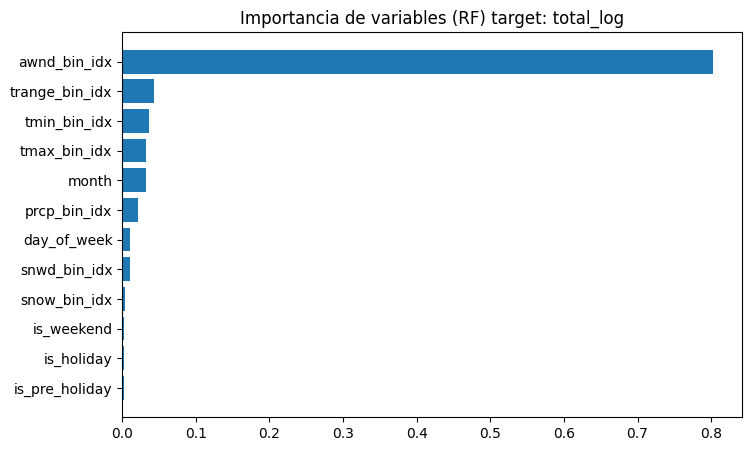

In [0]:
importances = rf_model1.stages[-1].featureImportances

feature_names = feature_cols

imp_df1 = pd.DataFrame({
    'feature': feature_names,
    'importance': importances.toArray()
}).sort_values('importance', ascending=False).head(15)

plt.figure(figsize=(8,5))
plt.barh(imp_df1['feature'], imp_df1['importance'])
plt.gca().invert_yaxis()
plt.title('Importancia de variables (RF) target: total_log')
plt.show()

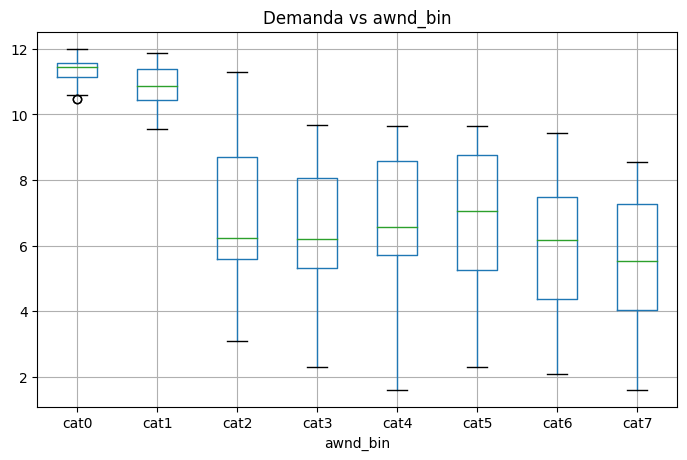

In [0]:
df = spark.table("hive_metastore.tfm.fact_bike_ml")

sample_pd = (
    fact_bike_pred.select("awnd_bin", "total_log")
      .sample(0.05, seed=42)
      .toPandas()
)

sample_pd.boxplot(column="total_log", by="awnd_bin", figsize=(8,5))
plt.title("Demanda vs awnd_bin")
plt.suptitle("")
plt.show()

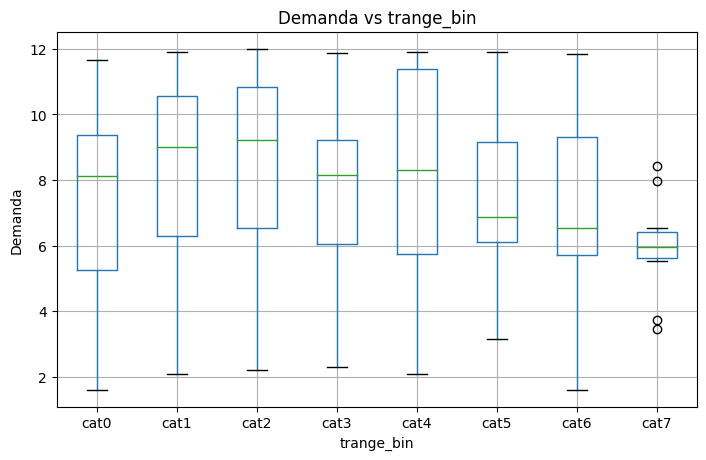

In [0]:
sample_pd = (
    fact_bike_pred.select('trange_bin', 'total_log')
      .sample(0.05, seed=42)
      .toPandas()
)

sample_pd.boxplot(
    column='total_log',
    by='trange_bin',
    figsize=(8,5)
)

plt.title('Demanda vs trange_bin')
plt.suptitle('')
plt.xlabel('trange_bin')
plt.ylabel('Demanda')
plt.show()

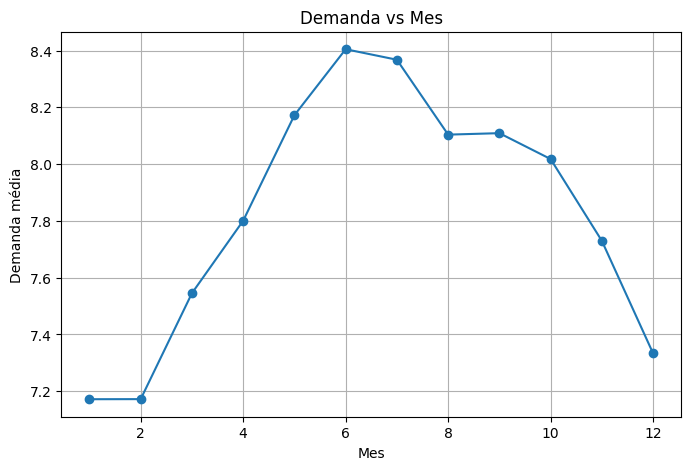

In [0]:
month_pd = (
    fact_bike_pred.groupBy('month')
      .agg(F.avg('total_log').alias('avg_demand'))
      .orderBy('month')
      .toPandas()
)

plt.figure(figsize=(8,5))
plt.plot(month_pd['month'], month_pd['avg_demand'], marker='o')
plt.title('Demanda vs Mes')
plt.xlabel('Mes')
plt.ylabel('Demanda média')
plt.grid(True)
plt.show()

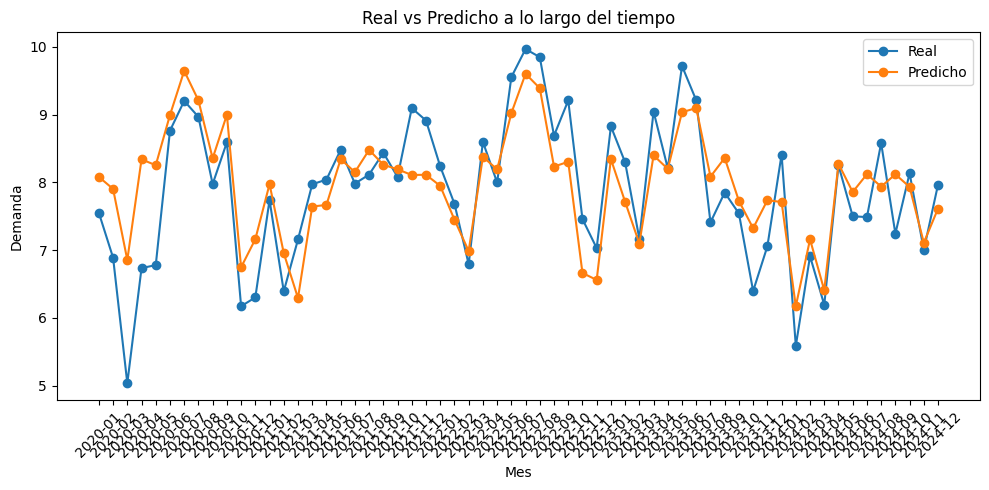

In [0]:
label_col = 'y1'

pred_test = rf_model1.transform(test_df)

ts_df = (
    pred_test
    .withColumn('year_month', F.date_format('date', 'yyyy-MM'))
    .groupBy('year_month')
    .agg(
        F.avg(label_col).alias('real'),
        F.avg('prediction').alias('pred')
    )
    .orderBy('year_month')
)

ts_pd = ts_df.toPandas()

plt.figure(figsize=(10,5))
plt.plot(ts_pd['year_month'], ts_pd['real'], label='Real', marker='o')
plt.plot(ts_pd['year_month'], ts_pd['pred'], label='Predicho', marker='o')
plt.xticks(rotation=45)
plt.title('Real vs Predicho a lo largo del tiempo')
plt.xlabel('Mes')
plt.ylabel('Demanda')
plt.legend()
plt.tight_layout()
plt.show()

## 5.2 Variable avg_distancia

In [0]:
df = fact_bike_pred
label_col = 'y1'

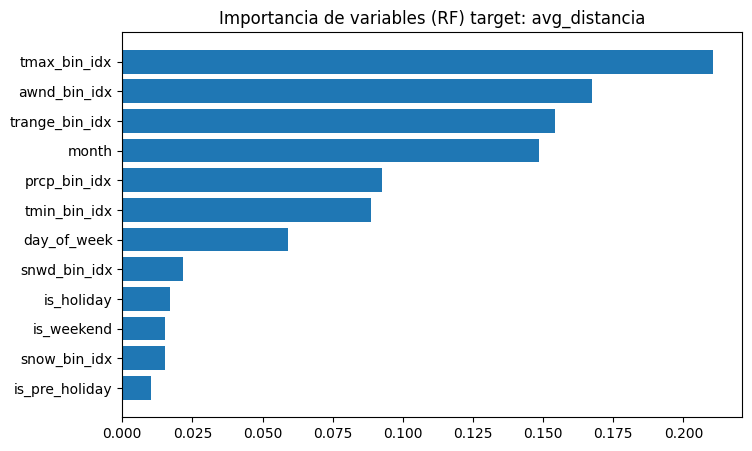

In [0]:
importances = rf_model2.stages[-1].featureImportances

feature_names = feature_cols

imp_df2 = pd.DataFrame({
    'feature': feature_names,
    'importance': importances.toArray()
}).sort_values('importance', ascending=False).head(15)

plt.figure(figsize=(8,5))
plt.barh(imp_df2['feature'], imp_df2['importance'])
plt.gca().invert_yaxis()
plt.title('Importancia de variables (RF) target: avg_distancia')
plt.show()

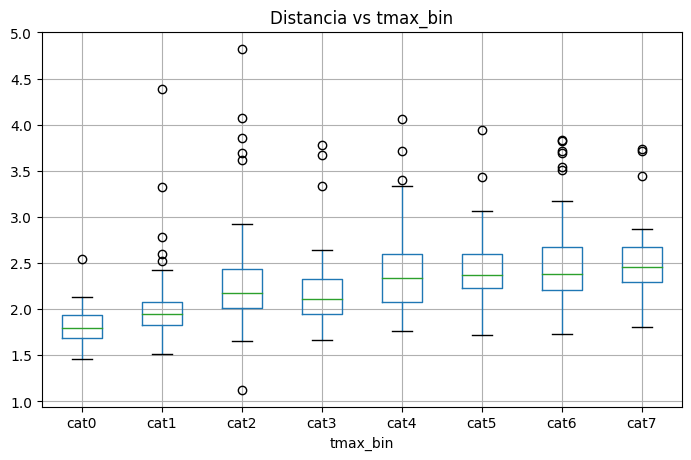

In [0]:
sample_pd = (
    fact_bike_pred.select("tmax_bin", "avg_distancia")
      .sample(0.05, seed=42)
      .toPandas()
)

sample_pd.boxplot(column="avg_distancia", by="tmax_bin", figsize=(8,5))
plt.title("Distancia vs tmax_bin")
plt.suptitle("")
plt.show()

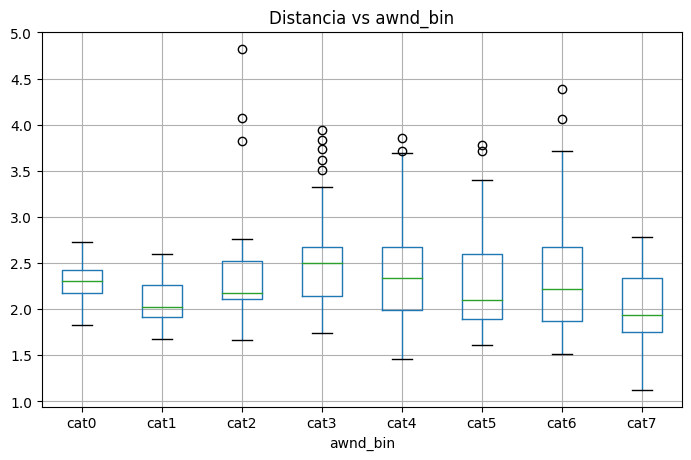

In [0]:
sample_pd = (
    fact_bike_pred.select("awnd_bin", "avg_distancia")
      .sample(0.05, seed=42)
      .toPandas()
)

sample_pd.boxplot(column="avg_distancia", by="awnd_bin", figsize=(8,5))
plt.title("Distancia vs awnd_bin")
plt.suptitle("")
plt.show()

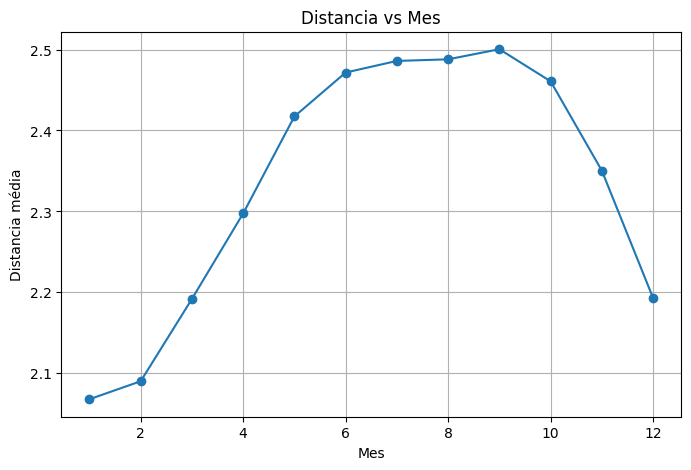

In [0]:
month_pd = (
    fact_bike_pred.groupBy('month')
      .agg(F.avg('avg_distancia').alias('avg_distancia'))
      .orderBy('month')
      .toPandas()
)

plt.figure(figsize=(8,5))
plt.plot(month_pd['month'], month_pd['avg_distancia'], marker='o')
plt.title('Distancia vs Mes')
plt.xlabel('Mes')
plt.ylabel('Distancia média')
plt.grid(True)
plt.show()

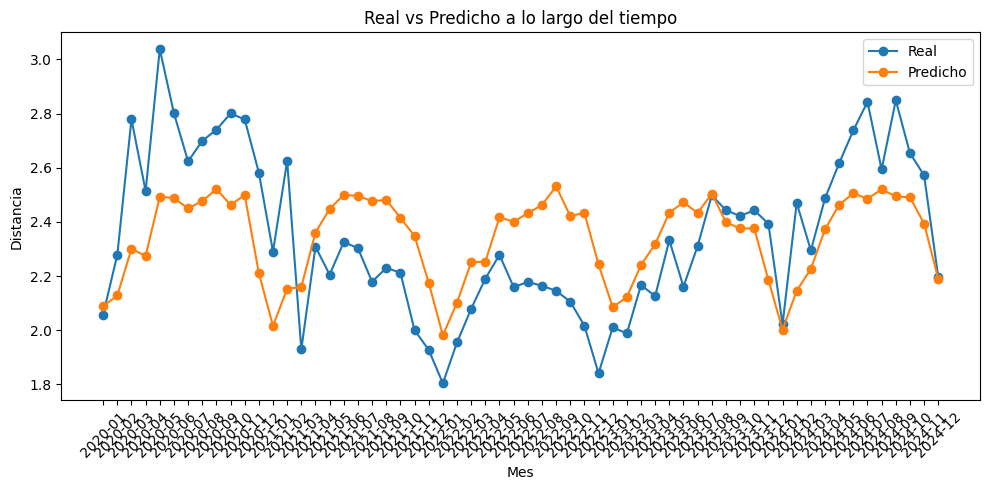

In [0]:
label_col = 'y2'

pred_test = rf_model2.transform(test_df)

ts_df = (
    pred_test
    .withColumn('year_month', F.date_format('date', 'yyyy-MM'))
    .groupBy('year_month')
    .agg(
        F.avg(label_col).alias('real'),
        F.avg('prediction').alias('pred')
    )
    .orderBy('year_month')
)

ts_pd = ts_df.toPandas()

plt.figure(figsize=(10,5))
plt.plot(ts_pd['year_month'], ts_pd['real'], label='Real', marker='o')
plt.plot(ts_pd['year_month'], ts_pd['pred'], label='Predicho', marker='o')
plt.xticks(rotation=45)
plt.title('Real vs Predicho a lo largo del tiempo')
plt.xlabel('Mes')
plt.ylabel('Distancia')
plt.legend()
plt.tight_layout()
plt.show()